In [2]:
import os
import pickle
import math
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset

In [3]:
PREPROCESSED_FILE = 'uklex18.pkl'
MAX_TOKEN_LENGTH = 512
RAW_DATA_FILE = 'uk-lex18.jsonl'
ID_HELD_OUT = 0.2
GROUP = 7

In [4]:
config = {
    'dataset': 'uklex18', # choices=['uklex18', 'uklex69', 'eurlex21', 'eurlex127', 'ecthr_a', 'ecthr_b']
    'method': 'erm', # choices=['erm', 'ewc', 'er', 'agem', 'lora', 'adapter', 'coral', 'irm', 'groupdro']
    'device': 0,  # 'gpu id'
    'random_seed': 1,  # 'random seed number'

    # Logging, saving, and testing options
    'data_dir': './data',  # 'directory for datasets.'
    'log_dir': './checkpoints',  # 'directory for summaries and checkpoints.'
    'results_dir': './results',  # 'directory for summaries and checkpoints.'
    'num_workers': 0  # 'number of workers in data generator'
}
from munch import DefaultMunch
args = DefaultMunch.fromDict(config)

In [233]:
raw_data_path = os.path.join(args.data_dir, RAW_DATA_FILE)
if not os.path.isfile(raw_data_path):
    raise ValueError(f'{RAW_DATA_FILE} is not in the data directory {args.data_dir}!')

# Load data frame from json file, group by year
base_df = pd.read_json(raw_data_path, lines=True)
base_df = base_df.sort_values(by=['year'])
base_df

,id,year,labels,title,body,data_type
0,UKSI19750515,1975,[SOCIAL SECURITY],The Social Security (Guardian's Allowances) Re...,"Citation, commencement and interpretation\n1 1...",train
1,UKSI19761267,1976,[SOCIAL SECURITY],The Child Benefit and Social Security (Fixing ...,"Citation, commencement and interpretation\n1 1...",train
2,UKSI19760965,1976,[SOCIAL SECURITY],The Child Benefit (General) Regulations 1976,"PART I\nGeneral\nCitation, commencement and in...",train
3,UKSI19790628,1979,[SOCIAL SECURITY],The Social Security (Claims and Payments) Regu...,P art I\nGENERAL\nCitation and commencement\n1...,train
4,UKSI19821163,1982,[TRANSPORTATION],The Motorways Traffic (England and Wales) Regu...,Commencement and citation\n1\nThese Regulation...,train
...,...,...,...,...,...,...
36450,UKSI20180626,2018,[SOCIAL SECURITY],The Scotland Act 1998 (Agency Arrangements) (S...,Citation\n1\nThis Order may be cited as the Sc...,test
36449,UKSI20180431,2018,[HEALTH CARE],The Plymouth Hospitals National Health Service...,"Citation, commencement and interpretation\n1\n...",test
36448,UKSI20180061,2018,[SOCIAL SECURITY],The Social Fund Funeral Expenses Amendment Reg...,Citation and commencement\n1\nThese Regulation...,test
36454,UKSI20180221,2018,[HOUSING],The Licensing of Houses in Multiple Occupation...,Citation and Commencement\n1\n1\nThis Order ma...,test


In [234]:
df_years = base_df.groupby(pd.Grouper(key='data_type'))
all_dfs = [group for _, group in df_years]
# all_years = list(base_df['data_type'].unique())
dfs = [all_dfs[0][:10000], all_dfs[0][10000:], all_dfs[1], all_dfs[2]]
# years = []
# dfs.append(pd.concat(all_dfs[:8]))
# years.append(all_years[7])
# all_dfs = all_dfs[8:]
# all_years = all_years[8:]
# for i in range(math.ceil(len(all_years)/GROUP)):
#     try:
#         dfs.append(pd.concat(all_dfs[GROUP*i:GROUP*i+GROUP]))
#         years.append(all_years[GROUP*i + 1])
#     except:
#         dfs.append(pd.concat(all_dfs[GROUP*i:]))
#         years.append(all_years[-1])

In [151]:
len(dfs[2])

8000

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import collections
import ast

In [235]:
labels_counts = {}
for i in range(4):
    all_labels = [label for lbs in dfs[i]['labels'] for label in lbs]
    labels_count = Counter(all_labels)
    for k in labels_count.keys():
        labels_count[k] = labels_count[k]/sum(labels_count.values())
    # if i == 5:
    #     labels_count['POLITICS'] = 0
    od = collections.OrderedDict(sorted(labels_count.items()))
    labels_counts[i+1] = list(od.values())

In [158]:
# len(labels_counts[4])

18

In [99]:
# categories_to_classids = {category: classid for classid, category in
#                               enumerate(sorted(list(set([i for sublist in base_df['labels'] for i in sublist]))))}
# categories_to_classids
# meta['labels'] = meta['labels'].apply(lambda x: [categories_to_classids[i] for i in x])
# meta['labels'] = meta['labels'].apply(lambda x: [1 if label in x else 0 for label in range(18)])
# meta

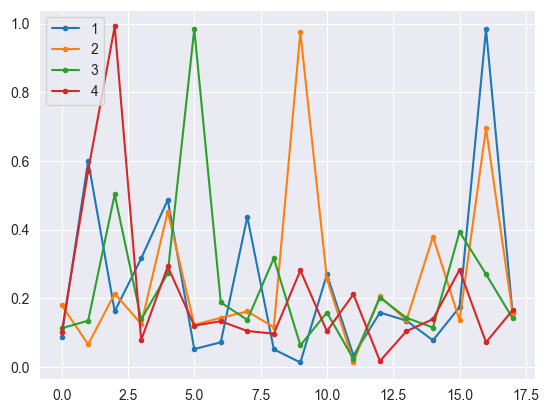

In [237]:
import matplotlib.pyplot as plt

for k, v in labels_counts.items():
    plt.plot(range(0, len(v)), v, '.-', label=k)
    # NOTE: changed `range(1, 4)` to mach actual values count
plt.legend()  # To draw legend
plt.show()

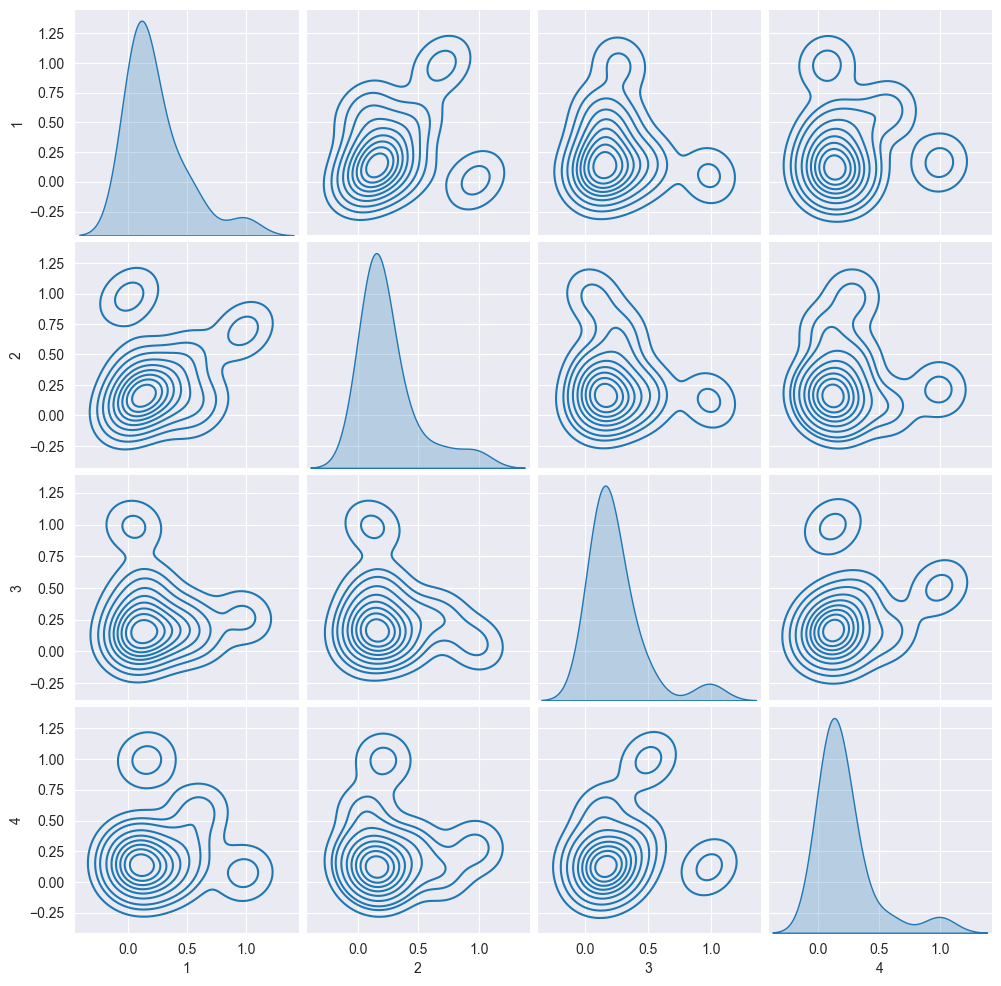

In [161]:
sns.pairplot(pd.DataFrame(labels_counts), diag_kind="kde", kind='kde')

In [112]:
labels_counts

{1: [0.0668878708014223,
  0.027089963517814175,
  0.9799424363314776,
  0.44373041808938146,
  0.055386695444692984,
  0.35345891386402783,
  0.3130466363007987,
  0.20644428220817235,
  0.09250755941114552,
  0.04515053121405155,
  0.29456837672853625,
  0.11205294356603443,
  0.5217118112012239,
  0.039811626097375256,
  0.32084094567132143,
  0.17184182601102133,
  0.28520374363330314,
  0.19124784253323318],
 2: [0.1411816003234757,
  0.17372280395896245,
  0.4772979503332635,
  0.09481849504035988,
  0.3512708923167889,
  0.07431447445332358,
  0.987747583543953,
  0.197107310101127,
  0.06937726439782708,
  0.18021857786709322,
  0.17146681334519115,
  0.2221704951651983,
  0.2995370173677979,
  0.26813503862385335,
  0.1274816104523753,
  0.1717652651885937,
  0.08388200113378286,
  0.1089920766537682],
 3: [0.03104368591094255,
  0.1183196771616693,
  0.07354468511272641,
  0.23876669788698035,
  0.07560535265731658,
  0.034067692434510924,
  0.8053715707004695,
  0.1851885661

In [97]:
for k in categories_to_classids.keys():
    if k not in od.keys():
        print(k)

POLITICS


In [ ]:
all_labels = [label for lbs in dfs[2]['labels'] for label in lbs]
all_labels

In [236]:
from math import log2
from scipy.special import rel_entr, kl_div
# calculate the jensen-shannon distance metric
from scipy.spatial.distance import jensenshannon
import numpy as np

# calculate the kl divergence
def kl_divergence(p, q):
	return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

mat = []
for k1, p in labels_counts.items():
    sub = []
    for k2, q in labels_counts.items():
        # print('P =', k1, ', Q =', k2)
        # calculate (P || Q)
        p = np.asarray(p)
        q = np.asarray(q)
        kl_pq = jensenshannon(p, q, base=2)
        sub.append(kl_pq)
        # print('KL(P|Q): %.3f' % kl_pq)
        # # calculate (Q || P)
        # kl_qp = rel_entr(q, p)
        # print('KL(Q || P): %.3f bits' % sum(kl_pq))
    mat.append(sub)
np.round(mat, 4)

array([[0.    , 0.4383, 0.4756, 0.4955],
       [0.4383, 0.    , 0.4545, 0.4774],
       [0.4756, 0.4545, 0.    , 0.4237],
       [0.4955, 0.4774, 0.4237, 0.    ]])

In [238]:
PREPROCESSED_FILE = 'uklex69.pkl'
MAX_TOKEN_LENGTH = 512
RAW_DATA_FILE = 'uk-lex69.jsonl'
ID_HELD_OUT = 0.2
GROUP = 7

raw_data_path = os.path.join(args.data_dir, RAW_DATA_FILE)
if not os.path.isfile(raw_data_path):
    raise ValueError(f'{RAW_DATA_FILE} is not in the data directory {args.data_dir}!')

# Load data frame from json file, group by year
base_df = pd.read_json(raw_data_path, lines=True)
base_df = base_df.sort_values(by=['year'])
df_years = base_df.groupby(pd.Grouper(key='data_type'))
all_dfs = [group for _, group in df_years]
# all_years = list(base_df['data_type'].unique())
dfs = [all_dfs[0][:10000], all_dfs[0][10000:], all_dfs[1], all_dfs[2]]

labels_counts = {}
for i in range(4):
    all_labels = [label for lbs in dfs[i]['labels'] for label in lbs]
    labels_count = Counter(all_labels)
    for k in labels_count.keys():
        labels_count[k] = labels_count[k]/sum(labels_count.values())
    if i == 0:
        labels_count['REFERENDUMS'] = 0
    od = collections.OrderedDict(sorted(labels_count.items()))
    labels_counts[i+1] = list(od.values())
    # labels_counts[i+1] = od

In [177]:
for k in labels_counts[2].keys():
    if k not in labels_counts[1].keys():
        print(k)

REFERENDUMS


In [239]:
from math import log2
from scipy.special import rel_entr, kl_div
# calculate the jensen-shannon distance metric
from scipy.spatial.distance import jensenshannon
import numpy as np

# calculate the kl divergence
def kl_divergence(p, q):
	return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

mat = []
for k1, p in labels_counts.items():
    sub = []
    for k2, q in labels_counts.items():
        # print('P =', k1, ', Q =', k2)
        # calculate (P || Q)
        p = np.asarray(p)
        q = np.asarray(q)
        kl_pq = jensenshannon(p, q, base=2)
        sub.append(kl_pq)
        # print('KL(P|Q): %.3f' % kl_pq)
        # # calculate (Q || P)
        # kl_qp = rel_entr(q, p)
        # print('KL(Q || P): %.3f bits' % sum(kl_pq))
    mat.append(sub)
np.round(mat, 4)

array([[0.    , 0.5924, 0.6181, 0.6129],
       [0.5924, 0.    , 0.5886, 0.5548],
       [0.6181, 0.5886, 0.    , 0.6125],
       [0.6129, 0.5548, 0.6125, 0.    ]])

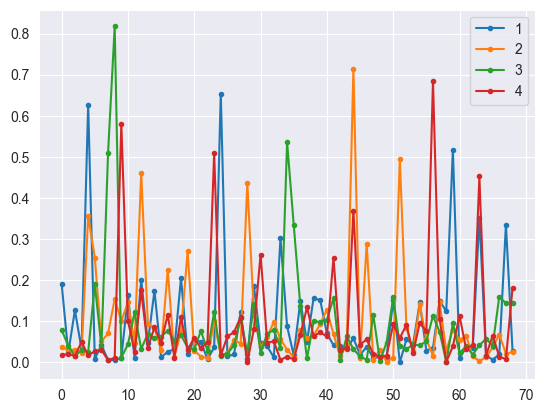

In [182]:
import matplotlib.pyplot as plt

for k, v in labels_counts.items():
    plt.plot(range(0, len(v)), v, '.-', label=k)
    # NOTE: changed `range(1, 4)` to mach actual values count
plt.legend()  # To draw legend
plt.show()

# ECTHR

In [240]:
PREPROCESSED_FILE = 'ecthr_a.pkl'
MAX_TOKEN_LENGTH = 128
RAW_DATA_FILE = ['ecthr-train.jsonl', 'ecthr-dev.jsonl', 'ecthr-test.jsonl']
ID_HELD_OUT = 0.2
GROUP = 1

In [241]:
base_dfs = []
for path in RAW_DATA_FILE:
    raw_data_path = os.path.join(args.data_dir, path)
    if not os.path.isfile(raw_data_path):
        raise ValueError(f'{path} is not in the data directory {args.data_dir}!')
    base_dfs.append(pd.read_json(raw_data_path, lines=True))
# Load data frame from json file, group by year
# base_df = pd.concat(base_dfs)
# base_df = base_df.sort_values(by=['judgment_date'])

dfs = [base_dfs[0][:4500], base_dfs[0][4500:], base_dfs[1], base_dfs[2]]

allowed = ['10', '11', '13', '14', '2', '3', '5', '6', '7', '8', '9', 'P1-1', 'P1-3', 'P4-2']
# # allowed = ['10', '11', '13', '14', '18', '2', '3', '4', '5', '6', '7', '8', '9', 'P1-1', 'P4-2', 'P7-1', 'P7-4']
all_dfs = []
for base_df in base_dfs:
    for i in range(len(base_df)):
        new_label = []
        for label in base_df.iloc[i, 8]:
            if label in allowed:
                new_label.append(label)
        base_df.iloc[i, 8] = new_label
    all_dfs.append(base_df)
# base_df['year'] = pd.DatetimeIndex(base_df['judgment_date']).year
# df_years = base_df.groupby(pd.Grouper(key='year'))
# all_dfs = [group for _, group in df_years]

In [242]:
labels_counts = {}
for i in range(4):
    all_labels = [label for lbs in dfs[i]['violated_articles'] for label in lbs]
    labels_count = Counter(all_labels)
    for k in labels_count.keys():
        labels_count[k] = labels_count[k]/sum(labels_count.values())
    # if i == 0:
    #     labels_count['REFERENDUMS'] = 0
    od = collections.OrderedDict(sorted(labels_count.items()))
    labels_counts[i+1] = list(od.values())

In [193]:
dfs[0].columns

Index(['case_id', 'case_no', 'title', 'judgment_date', 'facts', 'applicants',
       'defendants', 'allegedly_violated_articles', 'violated_articles',
       'court_assessment_references', 'silver_rationales', 'gold_rationales'],
      dtype='object')

In [243]:
from math import log2
from scipy.special import rel_entr, kl_div
# calculate the jensen-shannon distance metric
from scipy.spatial.distance import jensenshannon
import numpy as np

# calculate the kl divergence
def kl_divergence(p, q):
	return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

mat = []
for k1, p in labels_counts.items():
    sub = []
    for k2, q in labels_counts.items():
        # print('P =', k1, ', Q =', k2)
        # calculate (P || Q)
        p = np.asarray(p)
        q = np.asarray(q)
        kl_pq = jensenshannon(p, q, base=2)
        sub.append(kl_pq)
        # print('KL(P|Q): %.3f' % kl_pq)
        # # calculate (Q || P)
        # kl_qp = rel_entr(q, p)
        # print('KL(Q || P): %.3f bits' % sum(kl_pq))
    mat.append(sub)
np.round(mat, 4)

array([[0.    , 0.5006, 0.4084, 0.3534],
       [0.5006, 0.    , 0.4025, 0.3294],
       [0.4084, 0.4025, 0.    , 0.4213],
       [0.3534, 0.3294, 0.4213, 0.    ]])

In [207]:
from math import log2
from scipy.special import rel_entr, kl_div
# calculate the jensen-shannon distance metric
from scipy.spatial.distance import jensenshannon
import numpy as np

# calculate the kl divergence
def kl_divergence(p, q):
	return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

mat = []
for k1, p in labels_counts.items():
    sub = []
    for k2, q in labels_counts.items():
        # print('P =', k1, ', Q =', k2)
        # calculate (P || Q)
        p = np.asarray(p)
        q = np.asarray(q)
        kl_pq = jensenshannon(p, q, base=2)
        sub.append(kl_pq)
        # print('KL(P|Q): %.3f' % kl_pq)
        # # calculate (Q || P)
        # kl_qp = rel_entr(q, p)
        # print('KL(Q || P): %.3f bits' % sum(kl_pq))
    mat.append(sub)
np.round(mat, 4)

array([[0.    , 0.5006, 0.4084, 0.3534],
       [0.5006, 0.    , 0.4025, 0.3294],
       [0.4084, 0.4025, 0.    , 0.4213],
       [0.3534, 0.3294, 0.4213, 0.    ]])

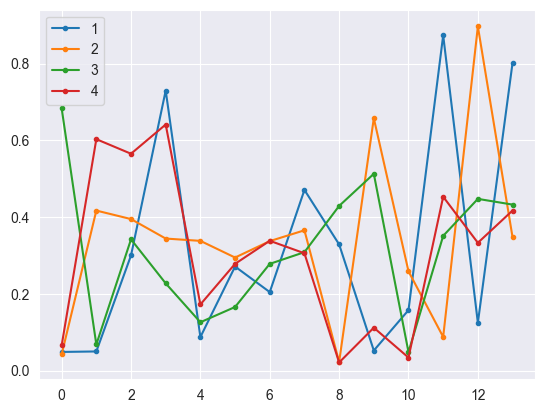

In [196]:
import matplotlib.pyplot as plt

for k, v in labels_counts.items():
    plt.plot(range(0, len(v)), v, '.-', label=k)
    # NOTE: changed `range(1, 4)` to mach actual values count
plt.legend()  # To draw legend
plt.show()

In [244]:
base_dfs = []
for path in RAW_DATA_FILE:
    raw_data_path = os.path.join(args.data_dir, path)
    if not os.path.isfile(raw_data_path):
        raise ValueError(f'{path} is not in the data directory {args.data_dir}!')
    base_dfs.append(pd.read_json(raw_data_path, lines=True))
# Load data frame from json file, group by year
# base_df = pd.concat(base_dfs)
# base_df = base_df.sort_values(by=['judgment_date'])

dfs = [base_dfs[0][:4500], base_dfs[0][4500:], base_dfs[1], base_dfs[2]]

# allowed = ['10', '11', '13', '14', '2', '3', '5', '6', '7', '8', '9', 'P1-1', 'P1-3', 'P4-2']
allowed = ['10', '11', '13', '14', '18', '2', '3', '4', '5', '6', '7', '8', '9', 'P1-1', 'P4-2', 'P7-1', 'P7-4']
all_dfs = []
for base_df in base_dfs:
    for i in range(len(base_df)):
        new_label = []
        for label in base_df.iloc[i, 7]:
            if label in allowed:
                new_label.append(label)
        base_df.iloc[i, 7] = new_label
    all_dfs.append(base_df)
# base_df['year'] = pd.DatetimeIndex(base_df['judgment_date']).year
# df_years = base_df.groupby(pd.Grouper(key='year'))
# all_dfs = [group for _, group in df_years]

labels_counts = {}
for i in range(4):
    all_labels = [label for lbs in dfs[i]['allegedly_violated_articles'] for label in lbs]
    labels_count = Counter(all_labels)
    for k in labels_count.keys():
        labels_count[k] = labels_count[k]/sum(labels_count.values())
    # if i == 0:
    #     labels_count['REFERENDUMS'] = 0
    od = collections.OrderedDict(sorted(labels_count.items()))
    labels_counts[i+1] = list(od.values())

from math import log2
from scipy.special import rel_entr, kl_div
# calculate the jensen-shannon distance metric
from scipy.spatial.distance import jensenshannon
import numpy as np

# calculate the kl divergence
def kl_divergence(p, q):
	return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

mat = []
for k1, p in labels_counts.items():
    sub = []
    for k2, q in labels_counts.items():
        # print('P =', k1, ', Q =', k2)
        # calculate (P || Q)
        p = np.asarray(p)
        q = np.asarray(q)
        kl_pq = jensenshannon(p, q, base=2)
        sub.append(kl_pq)
        # print('KL(P|Q): %.3f' % kl_pq)
        # # calculate (Q || P)
        # kl_qp = rel_entr(q, p)
        # print('KL(Q || P): %.3f bits' % sum(kl_pq))
    mat.append(sub)
np.round(mat, 4)

array([[0.    , 0.4148, 0.4075, 0.4316],
       [0.4148, 0.    , 0.4098, 0.4062],
       [0.4075, 0.4098, 0.    , 0.3286],
       [0.4316, 0.4062, 0.3286, 0.    ]])

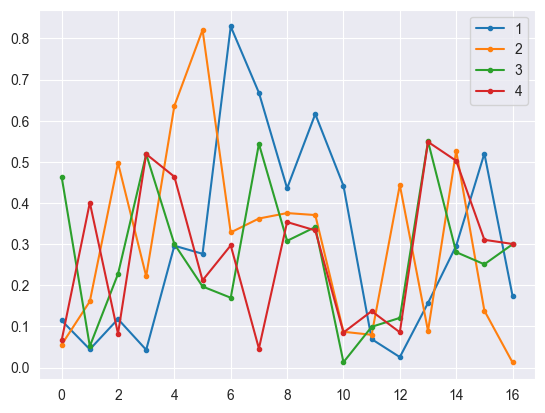

In [200]:
import matplotlib.pyplot as plt

for k, v in labels_counts.items():
    plt.plot(range(0, len(v)), v, '.-', label=k)
    # NOTE: changed `range(1, 4)` to mach actual values count
plt.legend()  # To draw legend
plt.show()

In [ ]:
base_dfs = []
for path in RAW_DATA_FILE:
    raw_data_path = os.path.join(args.data_dir, path)
    if not os.path.isfile(raw_data_path):
        raise ValueError(f'{path} is not in the data directory {args.data_dir}!')
    base_dfs.append(pd.read_json(raw_data_path, lines=True))
# Load data frame from json file, group by year
# base_df = pd.concat(base_dfs)
# base_df = base_df.sort_values(by=['judgment_date'])

dfs = [base_dfs[0][:4500], base_dfs[0][4500:], base_dfs[1], base_dfs[2]]

# allowed = ['10', '11', '13', '14', '2', '3', '5', '6', '7', '8', '9', 'P1-1', 'P1-3', 'P4-2']
allowed = ['10', '11', '13', '14', '18', '2', '3', '4', '5', '6', '7', '8', '9', 'P1-1', 'P4-2', 'P7-1', 'P7-4']
all_dfs = []
for base_df in base_dfs:
    for i in range(len(base_df)):
        new_label = []
        for label in base_df.iloc[i, 7]:
            if label in allowed:
                new_label.append(label)
        base_df.iloc[i, 7] = new_label
    all_dfs.append(base_df)
# base_df['year'] = pd.DatetimeIndex(base_df['judgment_date']).year
# df_years = base_df.groupby(pd.Grouper(key='year'))
# all_dfs = [group for _, group in df_years]

labels_counts = {}
for i in range(4):
    all_labels = [label for lbs in dfs[i]['allegedly_violated_articles'] for label in lbs]
    labels_count = Counter(all_labels)
    for k in labels_count.keys():
        labels_count[k] = labels_count[k]/sum(labels_count.values())
    # if i == 0:
    #     labels_count['REFERENDUMS'] = 0
    od = collections.OrderedDict(sorted(labels_count.items()))
    labels_counts[i+1] = list(od.values())

from math import log2
from scipy.special import rel_entr, kl_div
# calculate the jensen-shannon distance metric
from scipy.spatial.distance import jensenshannon
import numpy as np

# calculate the kl divergence
def kl_divergence(p, q):
	return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

mat = []
for k1, p in labels_counts.items():
    sub = []
    for k2, q in labels_counts.items():
        # print('P =', k1, ', Q =', k2)
        # calculate (P || Q)
        p = np.asarray(p)
        q = np.asarray(q)
        kl_pq = jensenshannon(p, q, base=2)
        sub.append(kl_pq)
        # print('KL(P|Q): %.3f' % kl_pq)
        # # calculate (Q || P)
        # kl_qp = rel_entr(q, p)
        # print('KL(Q || P): %.3f bits' % sum(kl_pq))
    mat.append(sub)
np.round(mat, 4)

# EURLEX

In [7]:
from datasets import load_dataset
dataset = load_dataset('multi_eurlex', language='en', label_level='level_1')

Found cached dataset multi_eurlex (/Users/luke/.cache/huggingface/datasets/multi_eurlex/default-label_level=level_1,language=en/1.0.0/5a12a7463045d4dcb12896b478c09b5a8a131a02b7e7bce059ba7ececc6584ee)


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
import re
dfs = []

splits = ['train', 'validation', 'test']
for x in splits:
    df = pd.DataFrame(columns=['celex_id', 'text', 'labels', 'year'])
    for i in dataset[x]:
        valid_months = ["January", "February", "March", "April", "May", "June", "July", "August", "September",
                        "October", "November", "December"]
        pattern = r'(\d{1,2})\s*(' + '|'.join(valid_months) + ')\s*(\d{4})'
        # matches = list(re.finditer(pattern, i['title'], re.IGNORECASE))

        # if len(matches) > 0:
        #     year = matches[0].group(3)
        # else:
        #
        matches = list(re.finditer(pattern, i['text'], re.IGNORECASE))
        if len(matches) > 0:
            year = matches[0].group(3)
        # else:
            # print(i['celex_id'], i['text'][:100], '\n')
        elif i['celex_id'] == '31988R0091':
            year = 1988
        elif i['celex_id'] in ['31987D0594', '31987D0593']:
            year = 1987

        df.loc[len(df)] = list(i.values()) + [int(year)]
    df = df.sort_values(by=['year'])
    if x == 'train':
        dfs += [df[:27500], df[27500:]]
    else:
        dfs.append(df)

labels_counts = {}
for i in range(4):
    all_labels = [label for lbs in dfs[i]['labels'] for label in lbs]
    labels_count = Counter(all_labels)
    for k in labels_count.keys():
        labels_count[k] = labels_count[k]/sum(labels_count.values())
    # if i == 0:
    #     labels_count['REFERENDUMS'] = 0
    od = collections.OrderedDict(sorted(labels_count.items()))
    labels_counts[i+1] = list(od.values())

from math import log2
from scipy.special import rel_entr, kl_div
# calculate the jensen-shannon distance metric
from scipy.spatial.distance import jensenshannon
import numpy as np

# calculate the kl divergence
def kl_divergence(p, q):
	return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

mat = []
for k1, p in labels_counts.items():
    sub = []
    for k2, q in labels_counts.items():
        # print('P =', k1, ', Q =', k2)
        # calculate (P || Q)
        p = np.asarray(p)
        q = np.asarray(q)
        kl_pq = jensenshannon(p, q, base=2)
        sub.append(kl_pq)
        # print('KL(P|Q): %.3f' % kl_pq)
        # # calculate (Q || P)
        # kl_qp = rel_entr(q, p)
        # print('KL(Q || P): %.3f bits' % sum(kl_pq))
    mat.append(sub)
np.round(mat, 4)

array([[0.    , 0.4478, 0.5882, 0.6148],
       [0.4478, 0.    , 0.4016, 0.5135],
       [0.5882, 0.4016, 0.    , 0.5374],
       [0.6148, 0.5135, 0.5374, 0.    ]])

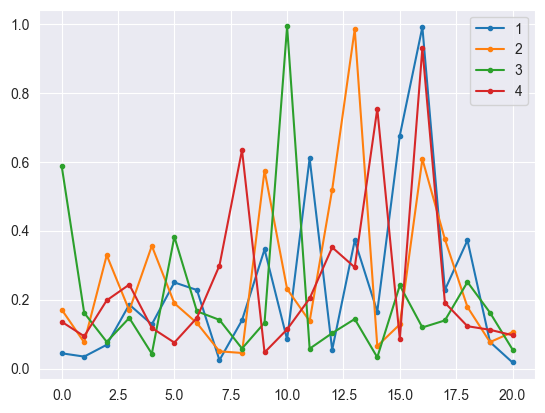

In [214]:
import matplotlib.pyplot as plt

for k, v in labels_counts.items():
    plt.plot(range(0, len(v)), v, '.-', label=k)
    # NOTE: changed `range(1, 4)` to mach actual values count
plt.legend()  # To draw legend
plt.show()

In [9]:
from datasets import load_dataset
dataset = load_dataset('multi_eurlex', language='en', label_level='level_2')

Found cached dataset multi_eurlex (/Users/luke/.cache/huggingface/datasets/multi_eurlex/default-label_level=level_2,language=en/1.0.0/5a12a7463045d4dcb12896b478c09b5a8a131a02b7e7bce059ba7ececc6584ee)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
import re
dfs = []

splits = ['train', 'validation', 'test']
for x in splits:
    df = pd.DataFrame(columns=['celex_id', 'text', 'labels', 'year'])
    for i in dataset[x]:
        valid_months = ["January", "February", "March", "April", "May", "June", "July", "August", "September",
                        "October", "November", "December"]
        pattern = r'(\d{1,2})\s*(' + '|'.join(valid_months) + ')\s*(\d{4})'
        # matches = list(re.finditer(pattern, i['title'], re.IGNORECASE))

        # if len(matches) > 0:
        #     year = matches[0].group(3)
        # else:
        #
        matches = list(re.finditer(pattern, i['text'], re.IGNORECASE))
        if len(matches) > 0:
            year = matches[0].group(3)
        # else:
            # print(i['celex_id'], i['text'][:100], '\n')
        elif i['celex_id'] == '31988R0091':
            year = 1988
        elif i['celex_id'] in ['31987D0594', '31987D0593']:
            year = 1987

        df.loc[len(df)] = list(i.values()) + [int(year)]
    df = df.sort_values(by=['year'])
    if x == 'train':
        dfs += [df[:27500], df[27500:]]
    else:
        dfs.append(df)

In [22]:
labels_counts = {}
for i in range(4):
    all_labels = [label for lbs in dfs[i]['labels'] for label in lbs]
    labels_count = Counter(all_labels)
    for k in labels_count.keys():
        labels_count[k] = labels_count[k]/sum(labels_count.values())
    if i in [0, 2]:
        labels_count[66] = 0
    od = collections.OrderedDict(sorted(labels_count.items()))
    labels_counts[i+1] = list(od.values())

from math import log2
from scipy.special import rel_entr, kl_div
# calculate the jensen-shannon distance metric
from scipy.spatial.distance import jensenshannon
import numpy as np

# calculate the kl divergence
def kl_divergence(p, q):
	return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

mat = []
for k1, p in labels_counts.items():
    sub = []
    for k2, q in labels_counts.items():
        # print('P =', k1, ', Q =', k2)
        # calculate (P || Q)
        p = np.asarray(p)
        q = np.asarray(q)
        kl_pq = jensenshannon(p, q, base=2)
        sub.append(kl_pq)
        # print('KL(P|Q): %.3f' % kl_pq)
        # # calculate (Q || P)
        # kl_qp = rel_entr(q, p)
        # print('KL(Q || P): %.3f bits' % sum(kl_pq))
    mat.append(sub)
np.round(mat, 4)

array([[0.    , 0.6711, 0.608 , 0.6165],
       [0.6711, 0.    , 0.5991, 0.6363],
       [0.608 , 0.5991, 0.    , 0.5414],
       [0.6165, 0.6363, 0.5414, 0.    ]])

In [19]:
for k in labels_counts[2].keys():
    if k not in labels_counts[1].keys():
        print(k)

66


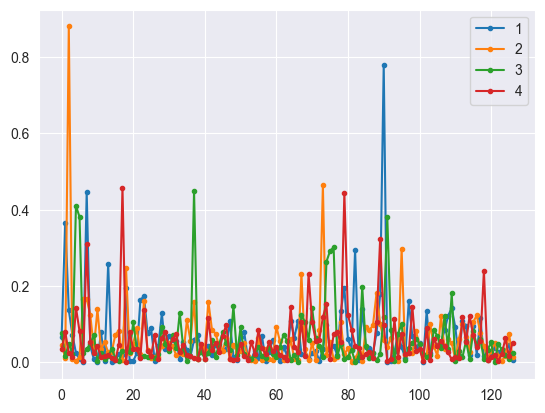

In [230]:
import matplotlib.pyplot as plt

for k, v in labels_counts.items():
    plt.plot(range(0, len(v)), v, '.-', label=k)
    # NOTE: changed `range(1, 4)` to mach actual values count
plt.legend()  # To draw legend
plt.show()